# i. Introduction

- Nama : Sihar Pangaribuan
- Batch : HCK-005
- Dataset : [Nike,Adidas Shoes for Image Classification Dataset](https://www.kaggle.com/datasets/ifeanyinneji/nike-adidas-shoes-for-image-classification-dataset)
- Objective : Membuat model deep learning CNN untuk memprediksi apakah sepatu bermerek adidas atau nike 
- Latar Belakang : Suatu perusahaan e-comerse jual beli sepatu second, ingin membuat automasi kategori berdasarkan merek, ketika konsumen upload gambar sepatu yang akan dijual akan otomatis masuk ke kategori merek tertentu, dalam projeck ini merek adidas dan nike

# ii. Import Libraries

In [1]:
import os
import glob 
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# iii. Data Loading

In [105]:
# Connect to gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# copy kagle.json to new folder
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle 

!mkdir ./kaggle 
!mv ./kaggle.json ./kaggle 

In [4]:
# Download dataset 
!kaggle datasets download -d ifeanyinneji/nike-adidas-shoes-for-image-classification-dataset

 35% 9.00M/25.7M [00:00<00:00, 73.7MB/s]
100% 25.7M/25.7M [00:00<00:00, 121MB/s] 


In [6]:
# Unzip dataset
!unzip -q /content/nike-adidas-shoes-for-image-classification-dataset.zip -d images

replace images/labelnames.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:

main_path= '/content/images' 
os.listdir(main_path)

['validation', 'labelnames.csv', 'test', 'train']

In [8]:
# initialization directory 
train_dir = os.path.join(main_path, 'train') 
test_dir = os.path.join(main_path, 'test')
val_dir = os.path.join(main_path, 'validation')
print(train_dir)

/content/images/train


In [9]:
train_adidas= glob.glob(train_dir + '/adidas/*.jpg')
train_nike= glob.glob(train_dir + '/nike/*.jpg')

val_adidas= glob.glob(val_dir + '/adidas/*.jpg')
val_nike= glob.glob(val_dir + '/nike/*.jpg')

test_adidas= glob.glob(test_dir + '/adidas/*.jpg')
test_nike= glob.glob(test_dir + '/nike/*.jpg')

In [10]:
# check sample directory train 
train_adidas[:6]

['/content/images/train/adidas/adidas_ (138).jpg',
 '/content/images/train/adidas/adidas_ (15).jpg',
 '/content/images/train/adidas/adidas_ (113).jpg',
 '/content/images/train/adidas/Adidas (35).jpg',
 '/content/images/train/adidas/adidas_ (21).jpg',
 '/content/images/train/adidas/adidas_ (127).jpg']

# iv. Exploratory Data Analysis (EDA)

In [11]:
# Check count data and category in directory
def check_dir(dir=None, labels=None):
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'jumlah {label} : {num_data}')

print('train set: \n' + '='*50) 
check_dir(train_dir,['adidas','nike'])

print('\ntest set: \n' + '='*50) 
check_dir(test_dir,['adidas','nike'])

print('\nval set: \n' + '='*50) 
check_dir(val_dir,['adidas','nike'])

train set: 
jumlah adidas : 230
jumlah nike : 230

test set: 
jumlah adidas : 30
jumlah nike : 30

val set: 
jumlah adidas : 27
jumlah nike : 28


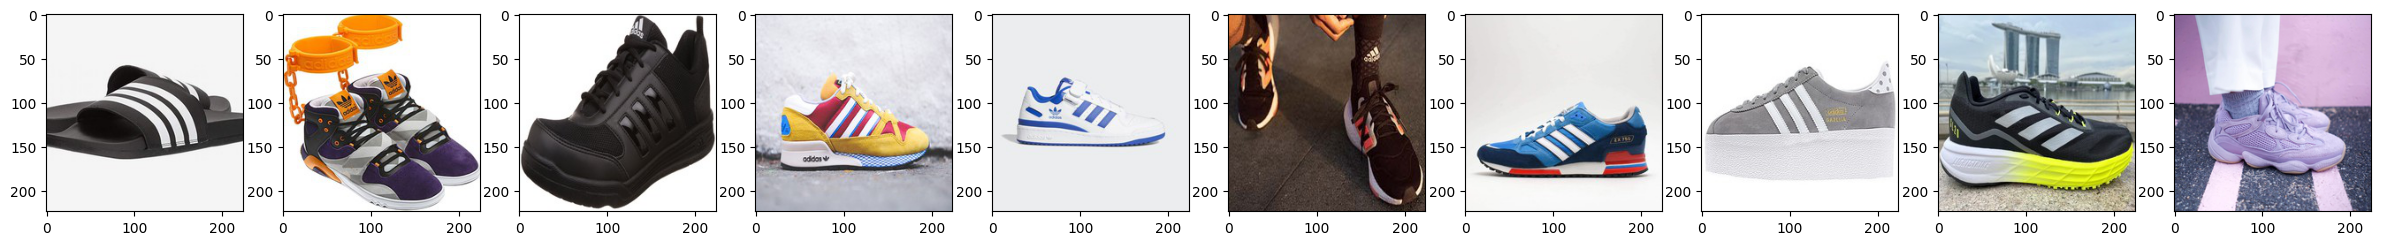

In [12]:
# Visualize sampel data train adidas
fig,ax = plt.subplots(ncols=10,figsize=(30,3))
for i in range(10):
  adidas = plt.imread(train_adidas[i])
  ax[i].imshow(adidas)

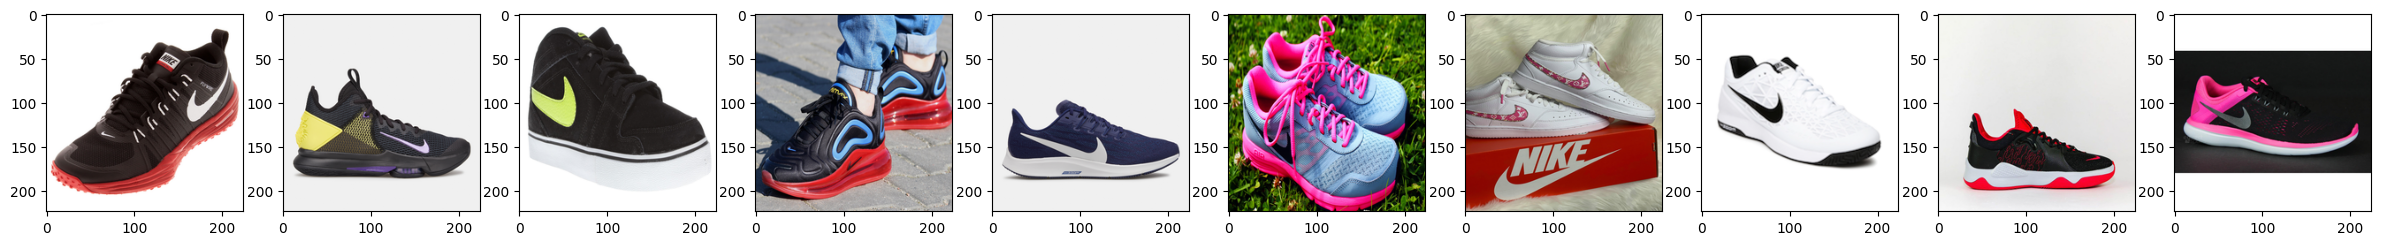

In [13]:
# Visualize sampel data train nike
fig,ax = plt.subplots(ncols=10,figsize=(30,3))
for i in range(10):
  adidas = plt.imread(train_nike[i])
  ax[i].imshow(adidas)

Dari hasil sample dilihat, bahwa data augmentasi tidak diperlukan, karena dari sample gambar sudah terlihat beragam.

# v. Feature Engineering

## v.1. Data Preproses

In [14]:
img_height= 224
img_width= 224
batch_size= 64

In [103]:
train_ds= tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split= 0.2,
    subset='training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size= batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split= 0.2,
    subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size= batch_size,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height,img_width),
    batch_size= batch_size,
    shuffle=False
)

Found 460 files belonging to 2 classes.
Using 368 files for training.
Found 460 files belonging to 2 classes.
Using 92 files for validation.
Found 60 files belonging to 2 classes.


In [98]:
print(train_ds.class_names)

['adidas', 'nike']


In [99]:
list_class= train_ds.class_names
nama_class= 'adidas'
class_index= list_class.index(nama_class)
print(class_index) 

0


In [61]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# vi. Model Definition

In [92]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    layers.Conv2D(16 ,3 , padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32 ,3 , padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64 ,3 , padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [93]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 56, 56, 64)      

# vii. Model Training

In [95]:
epochs= 20
history= model.fit(
    train_ds,
    validation_data= val_ds,
    epochs=epochs)

Epoch 1/20
6/6 [==============================] - 2s 169ms/step - loss: 0.2753 - accuracy: 0.8533 - val_loss: 0.2846 - val_accuracy: 0.8587
Epoch 2/20
6/6 [==============================] - 1s 100ms/step - loss: 0.2183 - accuracy: 0.9348 - val_loss: 0.1130 - val_accuracy: 0.9783
Epoch 3/20
6/6 [==============================] - 1s 86ms/step - loss: 0.1705 - accuracy: 0.9592 - val_loss: 0.0555 - val_accuracy: 1.0000
Epoch 4/20
6/6 [==============================] - 1s 86ms/step - loss: 0.1163 - accuracy: 0.9783 - val_loss: 0.1407 - val_accuracy: 0.9348
Epoch 5/20
6/6 [==============================] - 1s 86ms/step - loss: 0.0937 - accuracy: 0.9647 - val_loss: 0.0364 - val_accuracy: 1.0000
Epoch 6/20
6/6 [==============================] - 1s 91ms/step - loss: 0.0718 - accuracy: 0.9755 - val_loss: 0.0569 - val_accuracy: 1.0000
Epoch 7/20
6/6 [==============================] - 1s 95ms/step - loss: 0.0603 - accuracy: 0.9864 - val_loss: 0.0285 - val_accuracy: 1.0000
Epoch 8/20
6/6 [=========

# viii. Model Evaluation

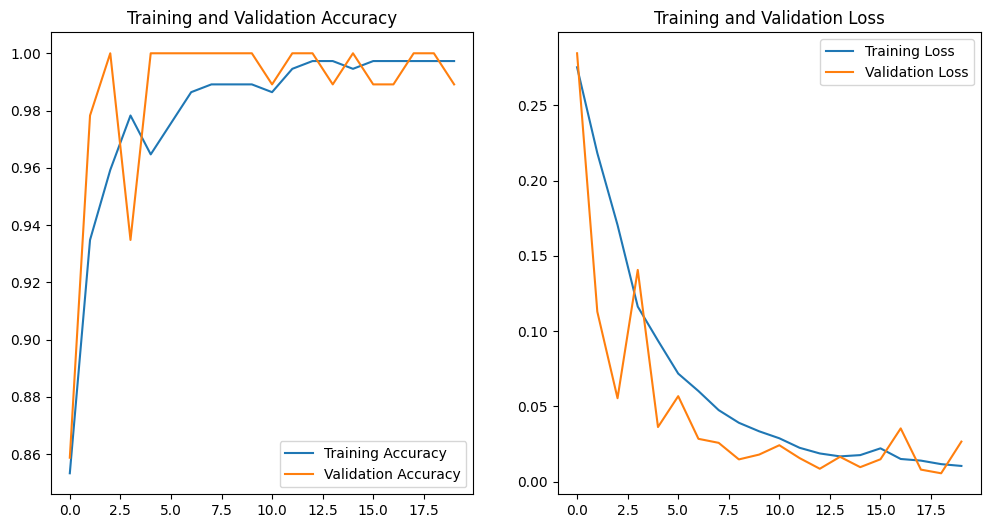

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [97]:
test_results_1 = model.evaluate(test_ds, verbose=0)
print(f'Test Loss     : {test_results_1[0]:.4f}')
print(f'Test Accuracy : {test_results_1[1]:.4f}')

Test Loss     : 2.5127
Test Accuracy : 0.5667


## Tuning

### Transfer learning

In [23]:
pretrained_model = tf.keras.applications.Xception(include_top=False, 
                                                  input_shape=(224,224,3),pooling='avg')
pretrained_model.trainable = False

83683744/83683744 [==============================] - 0s 0us/step


In [24]:
model_tf= Sequential()
model_tf.add(pretrained_model)

#fully connected layer
model_tf.add(Flatten())
model_tf.add(Dense(128, activation='relu')),
model_tf.add(Dense(units=1,activation='sigmoid'))

In [25]:
model_tf.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
model_tf.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,123,881
Trainable params: 262,401
Non-trainable params: 20,861,480
_________________________________________________________________


In [27]:
epochs= 30 
history_2= model_tf.fit(
    train_ds,
    validation_data= val_ds,
    epochs=epochs
)

Epoch 1/30
6/6 [==============================] - 14s 1s/step - loss: 9.0445 - accuracy: 0.5245 - val_loss: 0.3053 - val_accuracy: 0.9022
Epoch 2/30
6/6 [==============================] - 2s 302ms/step - loss: 2.4519 - accuracy: 0.6440 - val_loss: 0.1414 - val_accuracy: 0.9565
Epoch 3/30
6/6 [==============================] - 3s 355ms/step - loss: 2.4905 - accuracy: 0.6359 - val_loss: 0.1178 - val_accuracy: 0.9783
Epoch 4/30
6/6 [==============================] - 3s 304ms/step - loss: 2.0509 - accuracy: 0.6549 - val_loss: 0.0791 - val_accuracy: 0.9674
Epoch 5/30
6/6 [==============================] - 2s 307ms/step - loss: 1.5114 - accuracy: 0.6766 - val_loss: 0.1345 - val_accuracy: 0.9457
Epoch 6/30
6/6 [==============================] - 2s 306ms/step - loss: 1.4484 - accuracy: 0.7255 - val_loss: 0.1266 - val_accuracy: 0.9565
Epoch 7/30
6/6 [==============================] - 2s 309ms/step - loss: 1.2668 - accuracy: 0.7092 - val_loss: 0.2042 - val_accuracy: 0.8913
Epoch 8/30
6/6 [======

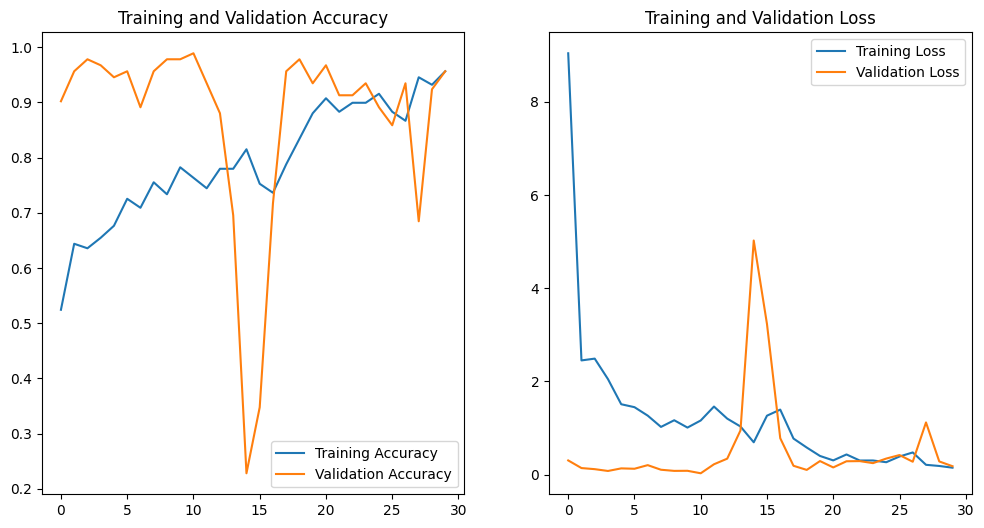

In [28]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [100]:

test_results_1 = model_tf.evaluate(test_ds, verbose=0)
print(f'Test Loss     : {test_results_1[0]:.4f}')
print(f'Test Accuracy : {test_results_1[1]:.4f}')

Test Loss     : 1.0739
Test Accuracy : 0.6333


# ix. Model Saving

In [29]:
# Saving best model 
model_tf.save('cnn.h5')

# x. Model Inference


In [106]:
# Fungsion 
def prediction(file):
  img = tf.keras.utils.load_img(file, target_size=(224, 224))
  x = tf.keras.utils.img_to_array(img)

  plt.imshow(x.astype('uint8'))

  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_tf.predict(images, batch_size=10)
  idx = np.argmax(classes)
  clas = ['adidas','nike',]
  print('Prediction is a {}'.format(clas[idx]))

1/1 [==============================] - 2s 2s/step
Prediction is a adidas


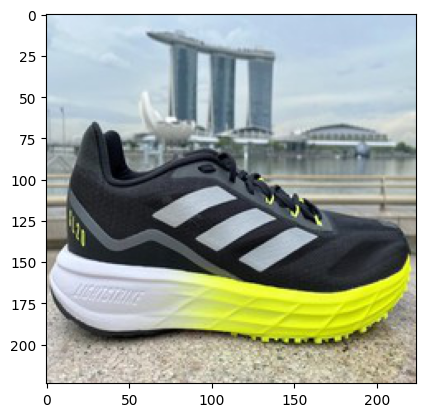

In [107]:
# Test predict
prediction('/content/images/test/adidas/Adidas (20).jpg')

1/1 [==============================] - 0s 24ms/step
Prediction is a adidas


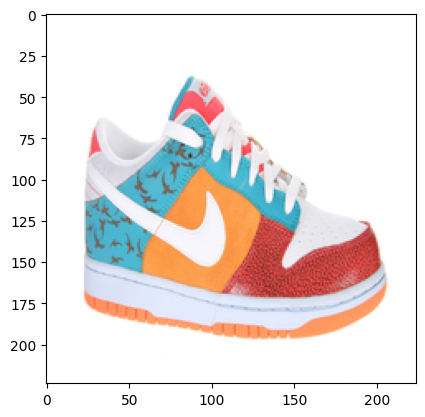

In [108]:
# Test predict
prediction('/content/images/test/nike/Image_180.jpg')

# xi. Conclusion

Model dibuat dengan sequential api, dan tanpa menggunakan Data Augmentatation. Hasil awal model dengan Test Loss : 2.5127 & Test Accuracy : 0.5667, setelah dilakukan transfer learning terdapat sedikit peningkatan Test Loss : 1.0739 & Test Accuracy : 0.6333. Hasil akhir model belum layak digunakanan, masih perlu di optimasi dengan data preroses yang lebih baik dan hyperparameter tuning.